In [ ]:
#Loading the drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Importing all the necessary Libraries
import numpy as np 
import pandas as pd 
import pywt
import matplotlib.pyplot as plt
%matplotlib inline 
import seaborn as sns
import time
import tensorflow
from tensorflow.keras.applications.inception_v3 import InceptionV3
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC, LinearSVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

import keras
from keras.layers import Dense, Flatten, Dropout
from keras.layers import Conv2D, MaxPooling2D
from keras.models import Sequential
from keras.callbacks import History 
from keras.applications.resnet50 import ResNet50
from keras.layers import Dense,Activation, Conv2D, MaxPool2D , Flatten
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.normalization import BatchNormalization
from keras.layers import Input
from keras.layers import Concatenate, Dense, LSTM, Input, concatenate
from keras.models import Model
from keras.datasets import mnist
from keras.layers import Dense, Dropout, LSTM
from keras.optimizers import Adam

np.random.seed(1000)

In [ ]:
#Attach the path to your dataset.
df=pd.read_csv('/content/drive/My Drive/Colab Notebooks/eardataset.csv')
df=pd.read_csv('/content/drive/My Drive/Colab Notebooks/eardataset.csv', encoding = "ISO-8859-1")

In [ ]:
#Checking for null values
print(df.info())
print("----Check if Data has any null values----")
print(df.isnull().sum())
if(df.isnull().values.any()==False):
    print("\nNo null Values in the dataset")
else:
    print("\ndataset has null values")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4320 entries, 0 to 4319
Columns: 666 entries, unnamed to data_659
dtypes: float64(660), int64(4), object(2)
memory usage: 22.0+ MB
None
----Check if Data has any null values----
unnamed     0
subject     0
session     0
ear         0
buffer      0
           ..
data_655    0
data_656    0
data_657    0
data_658    0
data_659    0
Length: 666, dtype: int64

No null Values in the dataset


In [ ]:
#Reading the csv file
df_again = pd.read_csv('/content/drive/My Drive/Colab Notebooks/eardataset.csv')
df_again.head(3)

,unnamed,subject,session,ear,buffer,block,data_0,data_1,data_2,data_3,data_4,data_5,data_6,data_7,data_8,data_9,data_10,data_11,data_12,data_13,data_14,data_15,data_16,data_17,data_18,data_19,data_20,data_21,data_22,data_23,data_24,data_25,data_26,data_27,data_28,data_29,data_30,data_31,data_32,data_33,...,data_620,data_621,data_622,data_623,data_624,data_625,data_626,data_627,data_628,data_629,data_630,data_631,data_632,data_633,data_634,data_635,data_636,data_637,data_638,data_639,data_640,data_641,data_642,data_643,data_644,data_645,data_646,data_647,data_648,data_649,data_650,data_651,data_652,data_653,data_654,data_655,data_656,data_657,data_658,data_659
0,40,0,0,left,A,40,0.000062,0.000063,0.000064,0.000067,0.000069,0.000072,0.000074,0.000077,0.000078,0.000080,0.000081,0.000083,0.000084,0.000085,0.000085,0.000085,0.000085,0.000085,0.000084,0.000083,0.000082,0.000081,0.000081,0.000081,0.000080,0.000080,0.000080,0.000081,0.000081,0.000082,0.000083,0.000084,0.000084,0.000085,...,-0.000063,-0.000063,-0.000064,-0.000063,-0.000063,-0.000062,-0.000061,-0.000061,-0.000060,-0.000059,-0.000057,-0.000056,-0.000056,-0.000054,-0.000052,-0.000051,-0.000050,-0.000049,-0.000047,-0.000046,-0.000044,-0.000043,-0.000042,-0.000042,-0.000042,-0.000042,-0.000042,-0.000043,-0.000044,-0.000045,-0.000046,-0.000048,-0.000049,-0.000051,-0.000052,-0.000052,-0.000053,-0.000053,-0.000052,-0.000051
1,41,0,0,left,A,41,0.000063,0.000064,0.000065,0.000067,0.000070,0.000072,0.000075,0.000077,0.000079,0.000080,0.000081,0.000083,0.000084,0.000085,0.000085,0.000085,0.000085,0.000084,0.000083,0.000082,0.000082,0.000081,0.000081,0.000081,0.000080,0.000079,0.000079,0.000080,0.000081,0.000081,0.000083,0.000083,0.000084,0.000084,...,-0.000055,-0.000055,-0.000055,-0.000055,-0.000054,-0.000053,-0.000052,-0.000052,-0.000052,-0.000050,-0.000049,-0.000048,-0.000047,-0.000045,-0.000044,-0.000042,-0.000041,-0.000040,-0.000039,-0.000038,-0.000036,-0.000035,-0.000034,-0.000034,-0.000034,-0.000034,-0.000035,-0.000036,-0.000036,-0.000037,-0.000039,-0.000040,-0.000042,-0.000043,-0.000044,-0.000044,-0.000044,-0.000044,-0.000044,-0.000042
2,42,0,0,left,A,42,0.000065,0.000066,0.000067,0.000069,0.000071,0.000074,0.000077,0.000079,0.000081,0.000082,0.000083,0.000085,0.000086,0.000087,0.000087,0.000087,0.000087,0.000086,0.000086,0.000084,0.000084,0.000083,0.000083,0.000082,0.000081,0.000081,0.000081,0.000082,0.000083,0.000083,0.000084,0.000085,0.000086,0.000086,...,-0.000059,-0.000059,-0.000059,-0.000058,-0.000057,-0.000057,-0.000056,-0.000056,-0.000056,-0.000054,-0.000052,-0.000051,-0.000051,-0.000049,-0.000047,-0.000046,-0.000045,-0.000044,-0.000042,-0.000041,-0.000040,-0.000039,-0.000038,-0.000037,-0.000037,-0.000037,-0.000038,-0.000039,-0.000039,-0.000040,-0.000042,-0.000043,-0.000045,-0.000046,-0.000047,-0.000047,-0.000047,-0.000047,-0.000047,-0.000045


In [ ]:
#Dropping columns that are not used
df_again=df_again.drop(["unnamed", "session","ear","buffer","block"],axis=1)

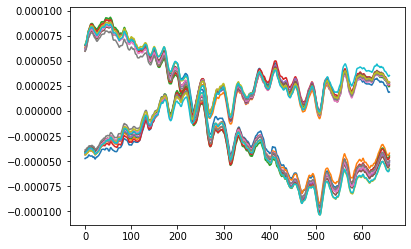

In [ ]:
#View the signals in the dataset
for i in range(0,20):
    disp = df_again.iloc[i,1:661].values
    plt.plot(disp)
#10 consecutive signals are similar in a dataset while the next consecutive 10 are not.

Text(18, 97.9, '  98.05%')

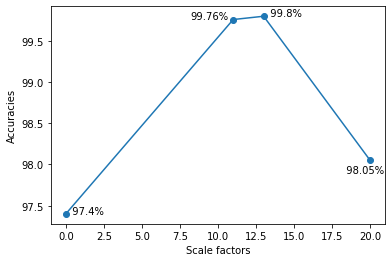

In [ ]:
#Scale factor testing
import matplotlib.pyplot as plt
import seaborn as sns

x_is = [0,11,13,20]
y_is = [97.4,99.76,99.8,98.05]

plt.xlabel("Scale factors")
plt.ylabel("Accuracies")

plt.scatter(x_is,y_is)
plt.plot(x_is,y_is)
plt.annotate("  97.4%", (0, 97.4))
plt.annotate("99.76%", (8.2, 99.76))
plt.annotate("  99.8%", (13, 99.8))
plt.annotate("  98.05%", (18, 97.9))

In [ ]:
#creating a dataFrame for the dataset
def subject0(subjectno, sessionno, earname, bufferid):
    dfu0=df.groupby(['subject', 'session', 'ear', 'buffer']).get_group((subjectno, sessionno, earname, bufferid)).iloc[-10:]
    return dfu0

x=subject0(34,0,'left','B')
x['subject'].iloc[0]
print(x.shape)
print(x)

(10, 666)
      unnamed  subject  session   ear  ...  data_656  data_657  data_658  data_659
2730    30662       34        0  left  ...  0.000009  0.000009  0.000009  0.000009
2731    30663       34        0  left  ...  0.000010  0.000010  0.000010  0.000010
2732    30664       34        0  left  ...  0.000010  0.000010  0.000010  0.000010
2733    30665       34        0  left  ...  0.000010  0.000010  0.000010  0.000010
2734    30666       34        0  left  ...  0.000010  0.000010  0.000010  0.000010
2735    30667       34        0  left  ...  0.000010  0.000010  0.000010  0.000010
2736    30668       34        0  left  ...  0.000010  0.000010  0.000010  0.000010
2737    30669       34        0  left  ...  0.000010  0.000010  0.000010  0.000010
2738    30670       34        0  left  ...  0.000009  0.000008  0.000008  0.000008
2739    30671       34        0  left  ...  0.000009  0.000008  0.000008  0.000008

[10 rows x 666 columns]


In [ ]:
#Creating Input and Labels DataFrame

allInputTEOAEsignalsAllSubjects = pd.DataFrame([])
allOutputLabelsAllSubjects = pd.DataFrame([])
for a in range(40):
    #print(a)
    df1 = pd.DataFrame([])
    b=[0,1]              # sessions 0 and 1
    c=['left','right']   # ears 
    d=['A','B']          # buffers
    
    allFeatures =  pd.DataFrame([])
    allInputFeatures =  pd.DataFrame([])
    outputLabel =  pd.DataFrame([])
    fftValues =  pd.DataFrame([])
    psdValues =  pd.DataFrame([])
    autocorrValues = pd.DataFrame([])
        
    for q,r,s in [(q,r,s) for q in b for r in c for s in d]:
        
        # df1 contains all the 80 TEOAE signals of subject a
        df1 = df1.append(subject0(a,q,r,s))
        allInputFeatures = df1.iloc[:,6:]
    
    allInputTEOAEsignalsAllSubjects = pd.concat([allInputTEOAEsignalsAllSubjects.reset_index(drop=True),
                                                 allInputFeatures.reset_index(drop=True)], axis=0)
    # the following gets you the class label <= subject no.[0,1,2,...,53]
    outputLabel = df1.iloc[:,1] 
    #print("OutputLabel:",outputLabel)
    #allOutputLabelsAllSubjects = allOutputLabelsAllSubjects.append(outputLabel)
    #append didn't work for output so using pd.cat instead
    allOutputLabelsAllSubjects = pd.concat([allOutputLabelsAllSubjects.reset_index(drop=True),
                                            outputLabel.reset_index(drop=True)], axis=0)
    #print(allInputTEOAEsignalsAllSubjects.shape)
    #print(allOutputLabelsAllSubjects.shape)


In [ ]:
# save extracted dataframe locally
X=pd.DataFrame([])
y=pd.DataFrame([])
xsave = pd.DataFrame([])
ysave = pd.DataFrame([])
X = allInputTEOAEsignalsAllSubjects
y = allOutputLabelsAllSubjects
xsave = X
ysave = y
xsave.to_pickle('dataX.pkl')
ysave.to_pickle('labelY.pkl')

In [ ]:
#Load from pkl files
X = pd.read_pickle('dataX.pkl')
y = pd.read_pickle('labelY.pkl')

In [ ]:
#Splitting 80% for training and 20% for testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)

In [ ]:
#Checking the dimensions of train and test array
print(np.asarray(X_train).shape)
print(np.asarray(X_test).shape)
print(np.asarray(y_train).shape)
print(np.asarray(y_test).shape)
labels_train = list(map(lambda x: int(x), np.asarray(y_train)))
print(np.asarray(labels_train).shape)

(2560, 660)
(640, 660)
(2560, 1)
(640, 1)
(2560,)


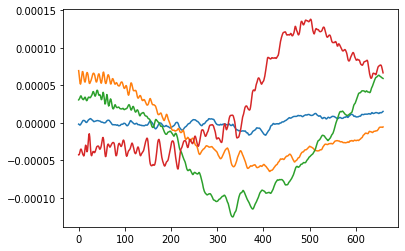

In [ ]:
# Check if continuous waves are similar to each other in X_train
for i in range(1,5):
    X_disp = X_train.iloc[i,:].values
    plt.plot(X_disp)
#Conclusion : NOPE!

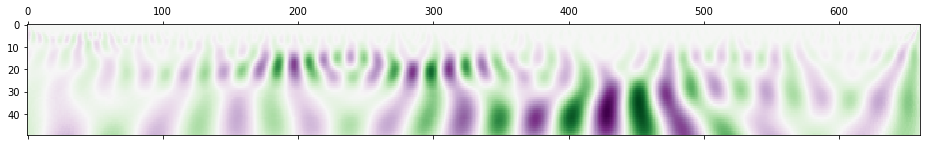

In [ ]:
#scales = range(1,661)
scales = range(1,51)
waveletname = 'morl'
train_size = 3456
test_size= 864

#################################################
### plotting CWT of a single TEOAE signal  ######
#################################################
coeff, freq = pywt.cwt(X_train.iloc[3,:], scales, waveletname, 1)
plt.matshow(coeff,  cmap='PRGn', aspect='auto')
plt.show()

In [ ]:
#CWT
scales = range(1,51)
waveletname = 'morl'
train_size = X_train.shape[0]
test_size= X_test.shape[0]

#########################################################
### creating a tensor to store CWT matrices of train egs#
#########################################################
train_data_cwt = np.ndarray(shape=(train_size, 50, 660)) 

for ii in range(0,train_size):
    # if ii % 50 == 0: #len(X_train) == 0:
    #     print(ii)
    signal = X_train.iloc[ii, :]
    coeff, freq = pywt.cwt(signal, scales, waveletname, 1)
    coeff_ = coeff[:,:660]
    train_data_cwt[ii, :, :] = coeff_
    #train_data_cwt[:, :, ii] = coeff_

###########################################################
### creating a tensor to store CWT matrices of test egs ###
###########################################################
test_data_cwt = np.ndarray(shape=(test_size, 50, 660))

for ii in range(0,test_size):
    # if ii % 50 == 0:
    #     print(ii)
    signal = X_test.iloc[ii, :]
    coeff, freq = pywt.cwt(signal, scales, waveletname, 1)
    coeff_ = coeff[:,:660]
    test_data_cwt[ii, :, :] = coeff_
    #test_data_cwt[:, :, ii] = coeff_

###########################################################
### convert the labels from float to int of train and test egs
###########################################################
labels_train = list(map(lambda x: int(x), np.asarray(y_train)))
labels_test = list(map(lambda x: int(x), np.asarray(y_test)))

###########################################################
### putting all the train and test CWT data             ###
###########################################################
x_train = train_data_cwt
y_train = list(labels_train[:train_size])
x_test = test_data_cwt
y_test = list(labels_test[:test_size])

In [ ]:
#Convert the labels to array
y_test_np = np.asarray(y_test)
y_train_np = np.asarray(y_train)

In [ ]:
#Printing shapes
print(np.asarray(x_train).shape)
print(np.asarray(x_test).shape)
print(np.asarray(y_train).shape)
print(np.asarray(y_test).shape)
print(len(x_train))
print(len(x_test))

(2560, 50, 660)
(640, 50, 660)
(2560,)
(640,)
2560
640


In [ ]:
# save numpy array
np.save('x_train_CNN', x_train)
np.save('x_test_CNN', x_test)
np.save('y_test_CNN', y_test_np)
np.save('y_train_CNN', y_train_np)

In [ ]:
#load data
x_train = np.load('x_train_CNN.npy')
x_test = np.load('x_test_CNN.npy')
y_train_np = np.load('y_train_CNN.npy')
y_test_np = np.load('y_test_CNN.npy')

In [ ]:
#ResNet50:
history = History()
 
img_x = x_train.shape[1] # = no.of samples of each TEOAE signal = 660
img_y = x_train.shape[2] 
img_z = 3

in_shape = (img_x, img_y, img_z)
print(in_shape)
base_model = ResNet50(weights='imagenet',include_top=False,input_shape=in_shape,classes=40)

(50, 660, 3)
94773248/94765736 [==============================] - 1s 0us/step


In [ ]:
#ResNet50:
model= Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(40,activation=('softmax')))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 2, 21, 2048)       23587712  
_________________________________________________________________
flatten (Flatten)            (None, 86016)             0         
_________________________________________________________________
dense (Dense)                (None, 40)                3440680   
Total params: 27,028,392
Trainable params: 26,975,272
Non-trainable params: 53,120
_________________________________________________________________


In [ ]:
#ResNet50:
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

print(x_train.shape)
print(x_test.shape)
num_classes = 40




x_train_cnn = x_train.reshape(2560,50,660,1)#len(x_train),img_x, img_y, img_z)
x_test_cnn = x_test.reshape(640,50,660,1)#len(x_test),img_x, img_y, img_z)
rgb_train = np.repeat(x_train_cnn, 3, -1)
rgb_test = np.repeat(x_test_cnn,3,-1)
y_train_cnn = keras.utils.to_categorical(y_train_np, num_classes)
y_test_cnn = keras.utils.to_categorical(y_test_np, num_classes)

(2560, 50, 660)
(640, 50, 660)


In [ ]:
#Compile the Model
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [ ]:
model.fit(rgb_train,y_train_cnn,epochs=5,batch_size=64,verbose=1)

Epoch 1/5
40/40 [==============================] - 1377s 34s/step - loss: 4.7531 - accuracy: 0.4470
Epoch 2/5
40/40 [==============================] - 1353s 34s/step - loss: 0.1301 - accuracy: 0.9887
Epoch 3/5
40/40 [==============================] - 1348s 34s/step - loss: 0.3769 - accuracy: 0.9854
Epoch 4/5
40/40 [==============================] - 1345s 34s/step - loss: 0.0427 - accuracy: 0.9915
Epoch 5/5
40/40 [==============================] - 1343s 34s/step - loss: 0.2775 - accuracy: 0.9740


In [ ]:
# saving the model
# evaluate the model
scores = model.evaluate(rgb_train, y_train_cnn, verbose=0)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

# serialize model to JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model_generalise.h5")
print("Saved model to disk")

accuracy: 2.70%
Saved model to disk


In [ ]:
#importing the model for feature extraction
# load json and create model
from keras.models import model_from_json
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("model_generalise.h5")
print("Loaded model from disk")

Loaded model from disk


In [ ]:
#loading the model
from keras.models import Model

model_14= Model(inputs=loaded_model.input, outputs=loaded_model.layers[-2].output)
model_14.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50_input (InputLayer)  [(None, 50, 660, 3)]      0         
_________________________________________________________________
resnet50 (Functional)        (None, 2, 21, 2048)       23587712  
_________________________________________________________________
flatten (Flatten)            (None, 86016)             0         
Total params: 23,587,712
Trainable params: 23,534,592
Non-trainable params: 53,120
_________________________________________________________________


In [ ]:
#Creating Input and Labels DataFrame

allInputTEOAEsignalsAllSubjects = pd.DataFrame([])
allOutputLabelsAllSubjects = pd.DataFrame([])
for a in range(40, 54):
    print(a)
    df1 = pd.DataFrame([])
    b=[0,1]              # sessions 0 and 1
    c=['left','right']   # ears 
    d=['A','B']          # buffers
    
    allFeatures =  pd.DataFrame([])
    allInputFeatures =  pd.DataFrame([])
    outputLabel =  pd.DataFrame([])
    fftValues =  pd.DataFrame([])
    psdValues =  pd.DataFrame([])
    autocorrValues = pd.DataFrame([])
        
    for q,r,s in [(q,r,s) for q in b for r in c for s in d]:
        
        # df1 contains all the 80 TEOAE signals of subject a
        df1 = df1.append(subject0(a,q,r,s))
        allInputFeatures = df1.iloc[:,6:]
    
    allInputTEOAEsignalsAllSubjects = pd.concat([allInputTEOAEsignalsAllSubjects.reset_index(drop=True),
                                                 allInputFeatures.reset_index(drop=True)], axis=0)
    # the following gets you the class label <= subject no.[0,1,2,...,53]
    outputLabel = df1.iloc[:,1] 
    print("OutputLabel:",outputLabel)
    #allOutputLabelsAllSubjects = allOutputLabelsAllSubjects.append(outputLabel)
    #append didn't work for output so using pd.cat instead
    allOutputLabelsAllSubjects = pd.concat([allOutputLabelsAllSubjects.reset_index(drop=True),
                                            outputLabel.reset_index(drop=True)], axis=0)
    print(allInputTEOAEsignalsAllSubjects.shape)
    print(allOutputLabelsAllSubjects.shape)


40
OutputLabel: 3200    40
3201    40
3202    40
3203    40
3204    40
        ..
3275    40
3276    40
3277    40
3278    40
3279    40
Name: subject, Length: 80, dtype: int64
(80, 660)
(80, 1)
41
OutputLabel: 3280    41
3281    41
3282    41
3283    41
3284    41
        ..
3355    41
3356    41
3357    41
3358    41
3359    41
Name: subject, Length: 80, dtype: int64
(160, 660)
(160, 1)
42
OutputLabel: 3360    42
3361    42
3362    42
3363    42
3364    42
        ..
3435    42
3436    42
3437    42
3438    42
3439    42
Name: subject, Length: 80, dtype: int64
(240, 660)
(240, 1)
43
OutputLabel: 3440    43
3441    43
3442    43
3443    43
3444    43
        ..
3515    43
3516    43
3517    43
3518    43
3519    43
Name: subject, Length: 80, dtype: int64
(320, 660)
(320, 1)
44
OutputLabel: 3520    44
3521    44
3522    44
3523    44
3524    44
        ..
3595    44
3596    44
3597    44
3598    44
3599    44
Name: subject, Length: 80, dtype: int64
(400, 660)
(400, 1)
45
OutputLabel: 3

In [ ]:
# save extracted dataframe locally
X=pd.DataFrame([])
y=pd.DataFrame([])
xsave = pd.DataFrame([])
ysave = pd.DataFrame([])
X = allInputTEOAEsignalsAllSubjects
y = allOutputLabelsAllSubjects
xsave = X
ysave = y
#xsave.to_pickle('dataX.pkl')

In [ ]:
#Splitting 80% for training and 20% for testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)

In [ ]:
#Checking the dimensions of train and test array
print(np.asarray(X_train).shape)
print(np.asarray(X_test).shape)
print(np.asarray(y_train).shape)
print(np.asarray(y_test).shape)
labels_train = list(map(lambda x: int(x), np.asarray(y_train)))
print(np.asarray(labels_train).shape)

(896, 660)
(224, 660)
(896, 1)
(224, 1)
(896,)


In [ ]:
t0=time.process_time()
scales = range(1,51)
waveletname = 'morl'
train_size = X_train.shape[0]
test_size= X_test.shape[0]

#########################################################
### creating a tensor to store CWT matrices of train egs#
#########################################################
train_data_cwt = np.ndarray(shape=(train_size, 50, 660)) 

for ii in range(0,train_size):
    if ii % 50 == 0: #len(X_train) == 0:
        print(ii)
    signal = X_train.iloc[ii, :]
    coeff, freq = pywt.cwt(signal, scales, waveletname, 1)
    coeff_ = coeff[:,:660]
    train_data_cwt[ii, :, :] = coeff_
    #train_data_cwt[:, :, ii] = coeff_

###########################################################
### creating a tensor to store CWT matrices of test egs ###
###########################################################
test_data_cwt = np.ndarray(shape=(test_size, 50, 660))

for ii in range(0,test_size):
    if ii % 50 == 0:
        print(ii)
    signal = X_test.iloc[ii, :]
    coeff, freq = pywt.cwt(signal, scales, waveletname, 1)
    coeff_ = coeff[:,:660]
    test_data_cwt[ii, :, :] = coeff_
    #test_data_cwt[:, :, ii] = coeff_

###########################################################
### convert the labels from float to int of train and test egs
###########################################################
labels_train = list(map(lambda x: int(x), np.asarray(y_train)))
labels_test = list(map(lambda x: int(x), np.asarray(y_test)))

###########################################################
### putting all the train and test CWT data             ###
###########################################################
x_train = train_data_cwt
y_train = list(labels_train[:train_size])
x_test = test_data_cwt
y_test = list(labels_test[:test_size])
t1=time.process_time()-t0
print("time taken: ",t1)

0
50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
0
50
100
150
200
time taken:  10.138059950000752


In [ ]:
#Convert the labels to array
y_test_np = np.asarray(y_test)
y_train_np = np.asarray(y_train)

In [ ]:
print(np.asarray(x_train).shape)
print(np.asarray(x_test).shape)
print(np.asarray(y_train).shape)
print(np.asarray(y_test).shape)
print(len(x_train))
print(len(x_test))

(896, 50, 660)
(224, 50, 660)
(896,)
(224,)
896
224


In [ ]:
#Compile the Model
model_14.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [ ]:
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

print(x_train.shape)
print(x_test.shape)
num_classes = 14

x_train_cnn = x_train.reshape(896,50,660,1)#len(x_train),img_x, img_y, img_z)
x_test_cnn = x_test.reshape(224,50,660,1)#len(x_test),img_x, img_y, img_z)
rgb_train = np.repeat(x_train_cnn, 3, -1)
rgb_test = np.repeat(x_test_cnn,3,-1)
#y_train_cnn = keras.utils.to_categorical(y_train_np, num_classes)
#y_test_cnn = keras.utils.to_categorical(y_test_np, num_classes)

(896, 50, 660)
(224, 50, 660)


In [ ]:
print(rgb_train.shape)
print(rgb_test.shape)


(896, 50, 660, 3)
(224, 50, 660, 3)


In [ ]:
#obtain the flattened output for training
t0=time.clock()
features_xtrain=model.predict(rgb_train) #training
features_xtrain.shape
t1=time.clock()-t0
print(t1)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  


205.91075999999885


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  """


In [ ]:
#Flattened output for Testing
t0=time.clock()
features_xtest=model.predict(rgb_test) #testing
features_xtest.shape
t1=time.clock()-t0
print(t1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  


50.92444400000022


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  """


In [ ]:
# PCA on the flattened array
t0=time.clock()
scaler = StandardScaler()
scaler.fit(features_xtrain)

features_xtrain = scaler.transform(features_xtrain)
features_xtest = scaler.transform(features_xtest)

pca = PCA(.95)  #using 95% of the variance in the model.

pca.fit(features_xtrain)

features_xtrain = pca.transform(features_xtrain)
features_xtest = pca.transform(features_xtest)
t1=time.clock()-t0
print(t1)

0.03654900000037742


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  from ipykernel import kernelapp as app


In [ ]:
#SVM classifier
t0=time.clock()
svm=SVC()
svm.fit(features_xtrain,y_train_np)

#training accuracy
acc_svm_train=round(svm.score(features_xtrain,y_train_np)*100,2)
print("Training Accuracy:",acc_svm_train)

#testing accuracy
acc_svm_test=round(svm.score(features_xtest,y_test_np)*100,2)
print("Testing accuracy:",acc_svm_test)
t1=time.clock()-t0
print(t1)

Training Accuracy: 85.38
Testing accuracy: 83.48
0.05902400000013586


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  del sys.path[0]


In [ ]:
# MLP classification
t0=time.clock()
mlp_clf = MLPClassifier(hidden_layer_sizes=(100,150,100), max_iter=50, alpha=0.0001,
                     solver='adam', verbose=10,  random_state=0,tol=0.000001)
mlp_clf.fit(features_xtrain, y_train_np)

pred_test = mlp_clf.predict(features_xtest) #testing accuracy
print(accuracy_score(y_test_np, pred_test)*100)
t1=time.clock()-t0
print(t1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  


Iteration 1, loss = 2.61517073
Iteration 2, loss = 2.25502436
Iteration 3, loss = 2.02302934
Iteration 4, loss = 1.82356279
Iteration 5, loss = 1.62855865
Iteration 6, loss = 1.44563255
Iteration 7, loss = 1.27551743
Iteration 8, loss = 1.13216381
Iteration 9, loss = 1.00886119
Iteration 10, loss = 0.89756325
Iteration 11, loss = 0.80402501
Iteration 12, loss = 0.72220905
Iteration 13, loss = 0.65262210
Iteration 14, loss = 0.59128540
Iteration 15, loss = 0.53994665
Iteration 16, loss = 0.49766382
Iteration 17, loss = 0.46201998
Iteration 18, loss = 0.42842970
Iteration 19, loss = 0.39607618
Iteration 20, loss = 0.37040614
Iteration 21, loss = 0.34945397
Iteration 22, loss = 0.32637155
Iteration 23, loss = 0.30902986
Iteration 24, loss = 0.29320775
Iteration 25, loss = 0.27898817
Iteration 26, loss = 0.26650311
Iteration 27, loss = 0.25334018
Iteration 28, loss = 0.23883639
Iteration 29, loss = 0.22923387
Iteration 30, loss = 0.21918990
Iteration 31, loss = 0.21196689
Iteration 32, los

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  if __name__ == '__main__':


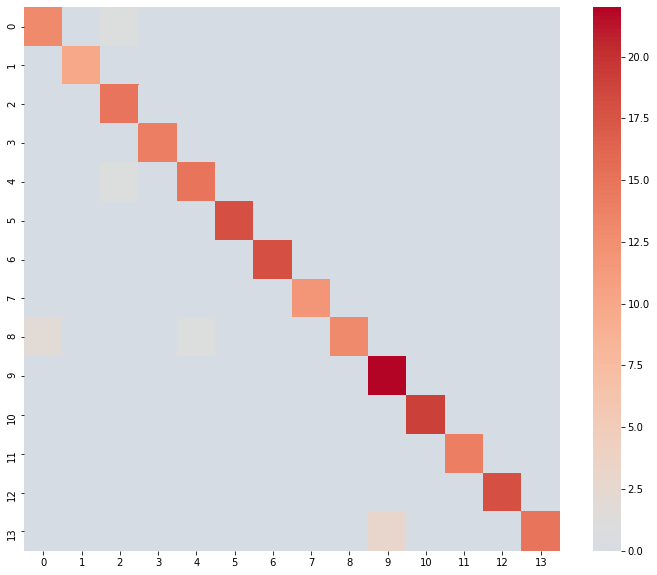

In [ ]:
# Plotting the Confusion matrix
cm = confusion_matrix(y_test_np, pred_test)
plt.figure(figsize=(12,10))
sns.heatmap(cm, center=True, cmap='coolwarm')
plt.show()

In [ ]:
#Random Forest Classifier

# Create the model with 100 trees

t0=time.clock()
model_rf = RandomForestClassifier(n_estimators=100, 
                               bootstrap = True,
                               max_features = 'sqrt')

model_rf.fit(features_xtrain, y_train_np)
pred_test = model_rf.predict(features_xtest) #testing accuracy

print(accuracy_score(y_test_np, pred_test)*100)
t1=time.clock()-t0
print(t1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  """


98.66071428571429
0.2758140000005369


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  


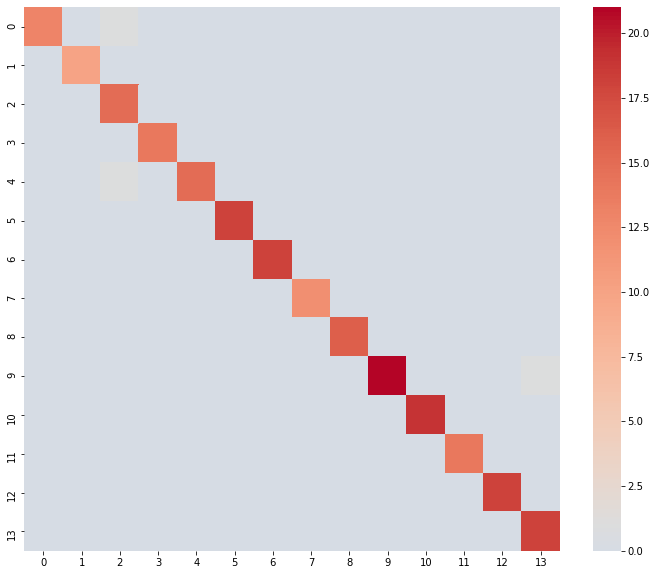

In [ ]:
# Plotting the Confusion matrix
cm = confusion_matrix(y_test_np, pred_test)

plt.figure(figsize=(12,10))
sns.heatmap(cm, center=True, cmap='coolwarm')
plt.show()

In [ ]:
# K nearest neighbours algorithm 
t0=time.clock()
knn = KNeighborsClassifier(n_neighbors=5) 
knn.fit(features_xtrain, y_train_np) 
pred_test = knn.predict(features_xtest) #testing accuracy
print(accuracy_score(y_test_np, pred_test)*100)
t1=time.clock()-t0
print(t1)

99.55357142857143
0.01515800000015588


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  import sys


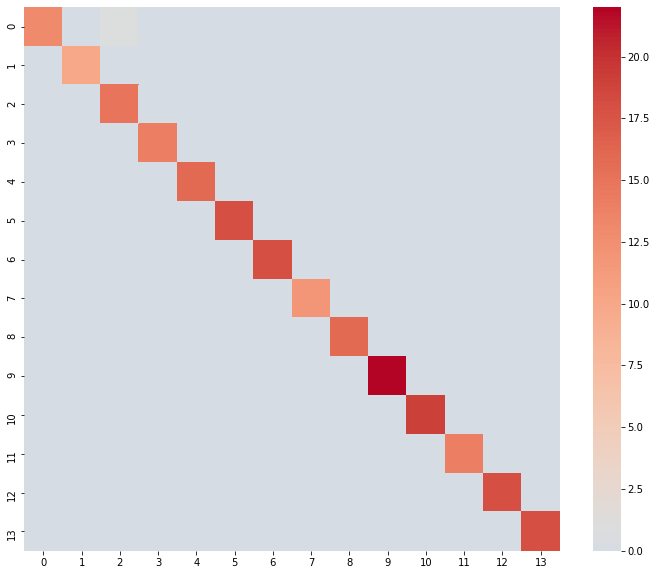

In [ ]:
cm = confusion_matrix(y_test_np, pred_test)

plt.figure(figsize=(12,10))
sns.heatmap(cm, center=True, cmap='coolwarm')
plt.show()

In [ ]:
# XGBoost classifier
t0=time.clock()
from xgboost import XGBClassifier
model = XGBClassifier()
model.fit(features_xtrain, y_train_np)
pred_test = model.predict(features_xtest) #testing accuracy
print(accuracy_score(y_test_np, pred_test)*100)
t1=time.clock()-t0
print(t1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  


96.42857142857143
0.5869800000000396


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  


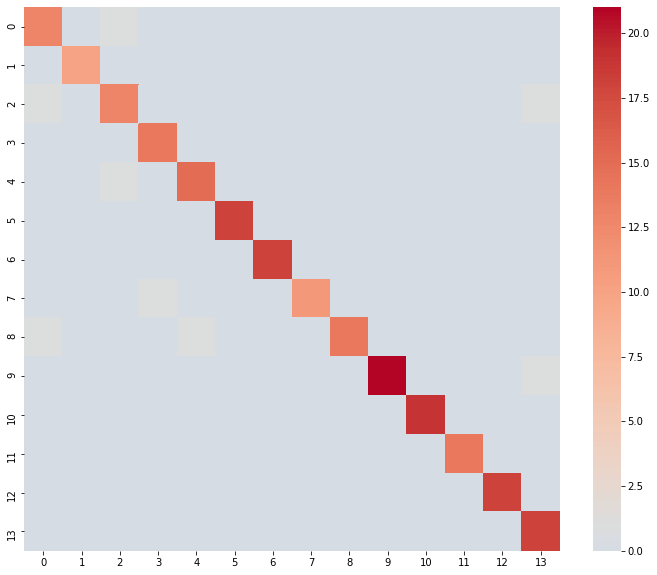

In [ ]:
cm = confusion_matrix(y_test_np, pred_test)

plt.figure(figsize=(12,10))
sns.heatmap(cm, center=True, cmap='coolwarm')
plt.show()